## Summary of the methodology and outcomes:

This analysis starts with a PCA with 4 components (capturing 80% of the variance as seen in the EDA). Using these components, we train multiple models using grid-search CV and predict the variants of the testing set. The output is not satisfying and the accuracy is very low.  
We therefore continue with a PCA with 26 components (capturing 90% of the variance as seen in the EDA) and do the predictions. The results are clearly improved.  

Changing the number of components has a big impact on the predictive power of the models. An analysis is therefore made to see the impact of the number of components on the final accuracy.  

The analysis shows out that about 89 (could be a bit less, or a bit more) components would lead to excellent results. We therefore run a PCA with 89 components and then apply an SVM to predict the testing set. The obtained accuracy is excellent with a very low training time. 

# Modelling

We saw previously that the best accuracy was obtained when using the full dataset. However, using the dataset using engineered features enable to reduce significantly the computational capacities required without decreasing the accuracy drastically.  
With the same idea, we aim at reducing the number of dimensions and to capture the most variance as possible using a reduced number of components. In the EDA, we saw that we could capture 80% of the variance with only 4 components.  
The idea is therefore not to tune the number of components in our grid search cross validation but rather to fix the number of components and to see how this affects the computation time as well as the accuracy. If the trade-off is acceptable, we might select this alternative as the best one. Otherwise, we might choose other number of components based on the output of our analysis.    
For the different models, we therefore start to run a PCA with 4 components and the apply the usual methdology. 

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
full_df = pd.read_pickle('datasets/full_df')

In [3]:
full_df.head()

,variant,nb_moves,nb_K,nb_Q,nb_R,nb_B,nb_N,nb_P,nb_k,nb_q,...,g8_b,g8_n,g8_p,h8_white,h8_q,h8_k,h8_r,h8_b,h8_n,h8_p
0,blitz,10,1,1,2,2,2,8,1,1,...,0,0,0,0,0,0,0,0,0,0
1,blitz,10,1,1,2,2,1,8,1,1,...,0,0,0,0,0,0,0,0,0,0
2,blitz,10,1,1,2,2,2,7,1,1,...,0,0,0,0,0,0,0,0,0,0
3,blitz,10,1,1,2,2,2,7,1,1,...,0,0,0,0,0,0,0,0,0,0
4,blitz,10,1,1,2,2,2,7,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
variants = ['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']

# Creating Train/Validation/Test set

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(
     full_df.drop('variant', axis=1), full_df['variant'], test_size=1/10, random_state=0, stratify =  full_df['variant'])

# X_tr, X_va, y_tr, y_va = train_test_split(
#    X_tr, y_tr, test_size=1/4, random_state=1, stratify = y_tr)

kfold = KFold(
    n_splits=5, 
    random_state=0) 

# Number of components

In [6]:
N=4

## PCA + Decision Tree

In [7]:
# Define our steps
pca = PCA(n_components=N)
model = DecisionTreeClassifier()

# grid 
grid = {
    'model__criterion': ['gini','entropy'], 
    'model__max_depth': [2,5,8,10,12,15,20,50,100,150]
}

# pipeline 
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [8]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_dt_tune_time = time.time() - start_time

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


In [9]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_dt_tune_time, 1)))

,param_model__criterion,param_model__max_depth,mean_test_score,std_test_score
12,entropy,8,0.625309,0.005353
13,entropy,10,0.623457,0.008868
3,gini,10,0.622469,0.007300
4,gini,12,0.614198,0.008598
2,gini,8,0.610617,0.008165
11,entropy,5,0.604198,0.005344
14,entropy,12,0.603951,0.006351
5,gini,15,0.597901,0.011258
6,gini,20,0.591481,0.009134
17,entropy,50,0.590864,0.004441


We can expect an accuracy close to 62.5% on the testing set with the following parameters: 
{'model__criterion': 'entropy', 'model__max_depth': 8}. 
The tuning time is 9.9 sec.


In [10]:
pipe.set_params(**grid_cv.best_params_)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [11]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_dt_train_time = time.time() - start_time

In [12]:
pca_dt_accuracy = pipe.score(X_te, y_te)
round(pca_dt_accuracy,3)

0.647

In [13]:
pca_dt_conf=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_dt_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.02,0.05,0.01,0.03,0.0,0.03,0.0,0.02
atomic,0.03,0.70,0.00,0.09,0.01,0.0,0.12,0.0,0.07
blitz,0.00,0.00,0.36,0.08,0.12,0.0,0.19,0.0,0.14
chess960,0.02,0.23,0.12,0.67,0.11,0.0,0.16,0.0,0.19
crazyhouse,0.02,0.00,0.13,0.05,0.56,0.0,0.10,0.0,0.14
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.04,0.31,0.08,0.10,0.0,0.37,0.0,0.20
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.01,0.03,0.02,0.07,0.0,0.03,0.0,0.24


In [14]:
pca_dt_metrics=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_dt_metrics

,f1-score,precision,recall,support
antichess,0.885,0.920,0.852,108.0
atomic,0.693,0.700,0.686,102.0
blitz,0.381,0.360,0.404,89.0
chess960,0.536,0.670,0.447,150.0
crazyhouse,0.560,0.560,0.560,100.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.351,0.370,0.333,111.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.343,0.240,0.600,40.0
micro avg,0.647,0.647,0.647,900.0


Disappointing first iteration, all the metrics show a poor performance.

## PCA + Logistic Regression

In [15]:
# Define our steps
pca = PCA(n_components=N)
model = LogisticRegression()

# grid 
grid = {
    'model__C': np.logspace(-3, 5, num=10),
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [16]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_log_tune_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_log_tune_time, 1)))

,param_model__C,mean_test_score,std_test_score
6,215.443,0.608642,0.009946
7,1668.1,0.608642,0.009946
8,12915.5,0.608642,0.009946
9,100000,0.608642,0.009946
5,27.8256,0.608272,0.009981
4,3.59381,0.607531,0.009606
3,0.464159,0.606667,0.009810
2,0.0599484,0.587407,0.008908
1,0.00774264,0.543704,0.011511
0,0.001,0.512963,0.009744


We can expect an accuracy close to 60.9% on the testing set with the following parameters: 
{'model__C': 215.44346900318823}. 
The tuning time is 5.1 sec.


In [18]:
pipe.set_params(**grid_cv.best_params_);

In [19]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_log_train_time = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [20]:
pca_log_accuracy = pipe.score(X_te, y_te)
pca_log_accuracy

0.6311111111111111

In [21]:
pca_log_conf=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_log_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.92,0.00,0.05,0.01,0.03,0.0,0.03,0.0,0.07
atomic,0.05,0.61,0.01,0.10,0.02,0.0,0.13,0.0,0.14
blitz,0.00,0.00,0.66,0.25,0.16,0.0,0.34,0.0,0.16
chess960,0.01,0.31,0.05,0.48,0.05,0.0,0.09,0.0,0.08
crazyhouse,0.02,0.01,0.14,0.06,0.67,0.0,0.19,0.0,0.28
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.00,0.03,0.06,0.06,0.03,0.0,0.14,0.0,0.07
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.04,0.03,0.04,0.04,0.0,0.08,0.0,0.20


In [22]:
pca_log_metrics=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_log_metrics

,f1-score,precision,recall,support
antichess,0.872,0.920,0.829,111.0
atomic,0.592,0.610,0.575,106.0
blitz,0.514,0.660,0.420,157.0
chess960,0.464,0.480,0.449,107.0
crazyhouse,0.565,0.670,0.489,137.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.201,0.140,0.359,39.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.280,0.200,0.465,43.0
micro avg,0.631,0.631,0.631,900.0


Again, using only 4 components seems not enough. The performance is clearly altered. Let's see if the other models do better.

## PCA + Random Forest

In [23]:
# Define our steps
pca = PCA(n_components=N)
model = RandomForestClassifier()

# grid 
grid = {
    'model__n_estimators': [10,50,100,500,1000],
    'model__max_depth': [1,2,5,10,20,50]
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [24]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_rf_tune_time = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


In [25]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_rf_tune_time, 1)))

,param_model__n_estimators,param_model__max_depth,mean_test_score,std_test_score
24,1000,20,0.653951,0.016062
28,500,50,0.653827,0.017281
19,1000,10,0.651975,0.010251
17,100,10,0.651728,0.010580
16,50,10,0.651481,0.009741
23,500,20,0.651481,0.013352
18,500,10,0.651111,0.008889
22,100,20,0.650864,0.012503
29,1000,50,0.650123,0.015903
26,50,50,0.648395,0.010809


We can expect an accuracy close to 65.4% on the testing set with the following parameters: 
{'model__max_depth': 20, 'model__n_estimators': 1000}. 
The tuning time is 122.8 sec.


In [26]:
pipe.set_params(**grid_cv.best_params_);

In [27]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_rf_train_time = time.time() - start_time

In [28]:
pca_rf_accuracy = pipe.score(X_te, y_te)
pca_rf_accuracy

0.6788888888888889

In [29]:
pca_rf_conf=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_rf_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.90,0.00,0.05,0.00,0.00,0.0,0.02,0.0,0.01
atomic,0.01,0.82,0.00,0.07,0.00,0.0,0.13,0.0,0.05
blitz,0.02,0.01,0.44,0.10,0.12,0.0,0.18,0.0,0.12
chess960,0.00,0.11,0.10,0.61,0.04,0.0,0.14,0.0,0.07
crazyhouse,0.03,0.01,0.14,0.06,0.66,0.0,0.15,0.0,0.20
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.02,0.20,0.09,0.05,0.0,0.31,0.0,0.18
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.03,0.03,0.07,0.07,0.13,0.0,0.07,0.0,0.37


In [30]:
pca_rf_metrics=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_rf_metrics

,f1-score,precision,recall,support
antichess,0.909,0.900,0.918,98.0
atomic,0.788,0.820,0.759,108.0
blitz,0.442,0.440,0.444,99.0
chess960,0.589,0.610,0.570,107.0
crazyhouse,0.587,0.660,0.528,125.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.333,0.310,0.360,86.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.418,0.370,0.481,77.0
micro avg,0.679,0.679,0.679,900.0


## PCA + SVM

In [31]:
# Define our steps
pca = PCA(n_components=N)
model = SVC()

# grid 
grid = {
    'model__C': np.logspace(-3,3,5), 
    'model__kernel': ['sigmoid', 'rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
    'model__gamma': np.logspace(-5,0,5)
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [32]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_svm_tune_time = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.4min finished


In [33]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_svm_tune_time, 1)))

,param_model__C,param_model__kernel,param_model__gamma,mean_test_score,std_test_score
45,1000,rbf,0.00316228,0.653333,0.005261
47,1000,rbf,0.0562341,0.653210,0.007086
37,31.6228,rbf,0.0562341,0.652593,0.005457
27,1,rbf,0.0562341,0.650000,0.005882
29,1,rbf,1,0.649753,0.007341
35,31.6228,rbf,0.00316228,0.644444,0.010285
43,1000,rbf,0.000177828,0.636667,0.007331
42,1000,sigmoid,0.000177828,0.633333,0.007428
41,1000,rbf,1e-05,0.628395,0.007146
33,31.6228,rbf,0.000177828,0.625802,0.006867


We can expect an accuracy close to 65.3% on the testing set with the following parameters: 
{'model__C': 1000.0, 'model__gamma': 0.0031622776601683794, 'model__kernel': 'rbf'}. 
The tuning time is 144.5 sec.


In [34]:
pipe.set_params(**grid_cv.best_params_);

In [35]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_svm_train_time = time.time() - start_time

In [36]:
pca_svm_accuracy = pipe.score(X_te, y_te)
pca_svm_accuracy

0.6855555555555556

In [37]:
pca_svm_conf=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_svm_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.93,0.02,0.05,0.00,0.01,0.0,0.03,0.0,0.03
atomic,0.02,0.81,0.02,0.15,0.02,0.0,0.13,0.0,0.03
blitz,0.00,0.00,0.56,0.12,0.17,0.0,0.27,0.0,0.19
chess960,0.01,0.11,0.10,0.56,0.05,0.0,0.13,0.0,0.09
crazyhouse,0.02,0.00,0.08,0.03,0.66,0.0,0.07,0.0,0.14
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.14,0.07,0.06,0.0,0.24,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.01,0.05,0.05,0.07,0.03,0.0,0.13,0.0,0.41


In [38]:
pca_svm_metrics=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_svm_metrics

,f1-score,precision,recall,support
antichess,0.899,0.930,0.869,107.0
atomic,0.743,0.810,0.686,118.0
blitz,0.485,0.560,0.427,131.0
chess960,0.546,0.560,0.533,105.0
crazyhouse,0.660,0.660,0.660,100.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.293,0.240,0.375,64.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.469,0.410,0.547,75.0
micro avg,0.686,0.686,0.686,900.0


## PCA + Neural Network

In [39]:
# Define our steps
pca = PCA(n_components=N)
model = MLPClassifier()

# grid 
grid = {'model__hidden_layer_sizes': [5,10,15,20,50,100],
        'model__alpha': np.logspace(-5,5,5),
        'model__solver': ['adam', 'sgd'],
        'model__activation': ['logistic', 'relu']
       }  

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [40]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_nnet_tune_time = time.time() - start_time

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.7min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [41]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_nnet_tune_time, 1)))

,param_model__hidden_layer_sizes,param_model__alpha,param_model__solver,param_model__activation,mean_test_score,std_test_score
70,100,1e-05,adam,relu,0.652963,0.006396
82,100,0.00316228,adam,relu,0.651728,0.007976
68,50,1e-05,adam,relu,0.651358,0.006165
80,50,0.00316228,adam,relu,0.650741,0.007329
66,20,1e-05,adam,relu,0.647778,0.009552
94,100,1,adam,relu,0.647654,0.008915
10,100,1e-05,adam,logistic,0.647407,0.007928
22,100,0.00316228,adam,logistic,0.647284,0.008559
76,15,0.00316228,adam,relu,0.646296,0.008877
20,50,0.00316228,adam,logistic,0.645556,0.010442


We can expect an accuracy close to 65.3% on the testing set with the following parameters: 
{'model__activation': 'relu', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': 100, 'model__solver': 'adam'}. 
The tuning time is 286.4 sec.


In [42]:
pipe.set_params(**grid_cv.best_params_);

In [43]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_nnet_train_time = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [44]:
pca_nnet_accuracy = pipe.score(X_te, y_te)
pca_nnet_accuracy

0.6788888888888889

In [45]:
pca_nnet_conf=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_nnet_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.90,0.02,0.04,0.00,0.01,0.0,0.03,0.0,0.02
atomic,0.01,0.77,0.01,0.12,0.01,0.0,0.12,0.0,0.02
blitz,0.00,0.00,0.47,0.08,0.11,0.0,0.20,0.0,0.14
chess960,0.03,0.14,0.10,0.60,0.06,0.0,0.17,0.0,0.12
crazyhouse,0.02,0.00,0.16,0.07,0.75,0.0,0.14,0.0,0.22
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.02,0.01,0.17,0.07,0.03,0.0,0.24,0.0,0.10
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.06,0.05,0.06,0.03,0.0,0.10,0.0,0.38


In [46]:
pca_nnet_metrics=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_nnet_metrics

,f1-score,precision,recall,support
antichess,0.891,0.900,0.882,102.0
atomic,0.748,0.770,0.726,106.0
blitz,0.470,0.470,0.470,100.0
chess960,0.541,0.600,0.492,122.0
crazyhouse,0.636,0.750,0.551,136.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.293,0.240,0.375,64.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.447,0.380,0.543,70.0
micro avg,0.679,0.679,0.679,900.0


# Results

In [47]:
pca_dt_scores_avg=list(pca_dt_metrics.loc['weighted avg',:])[:3]
pca_dt_scores_blitz=list(pca_dt_metrics.loc['blitz',:])
pca_log_scores_avg=list(pca_log_metrics.loc['weighted avg',:])[:3]
pca_log_scores_blitz=list(pca_log_metrics.loc['blitz',:])
pca_rf_scores_avg=list(pca_rf_metrics.loc['weighted avg',:])[:3]
pca_rf_scores_blitz=list(pca_rf_metrics.loc['blitz',:])
pca_svm_scores_avg=list(pca_svm_metrics.loc['weighted avg',:])[:3]
pca_svm_scores_blitz=list(pca_svm_metrics.loc['blitz',:])
pca_nnet_scores_avg=list(pca_nnet_metrics.loc['weighted avg',:])[:3]
pca_nnet_scores_blitz=list(pca_nnet_metrics.loc['blitz',:])

In [48]:
results_pca=pd.DataFrame({
              'decision tree': [pca_dt_accuracy, pca_dt_tune_time, pca_dt_train_time, pca_dt_scores_avg[0], pca_dt_scores_avg[1], pca_dt_scores_avg[2], pca_dt_scores_blitz[0], pca_dt_scores_blitz[1], pca_dt_scores_blitz[2], pca_dt_scores_blitz[3]],
              'logistic': [pca_log_accuracy, pca_log_tune_time, pca_log_train_time, pca_log_scores_avg[0], pca_log_scores_avg[1], pca_log_scores_avg[2], pca_log_scores_blitz[0], pca_log_scores_blitz[1], pca_log_scores_blitz[2], pca_log_scores_blitz[3]],
              'random forest': [pca_rf_accuracy, pca_rf_tune_time, pca_rf_train_time, pca_rf_scores_avg[0], pca_rf_scores_avg[1], pca_rf_scores_avg[2], pca_rf_scores_blitz[0], pca_rf_scores_blitz[1], pca_rf_scores_blitz[2], pca_rf_scores_blitz[3]],
              'SVM': [pca_svm_accuracy, pca_svm_tune_time, pca_svm_train_time, pca_svm_scores_avg[0], pca_svm_scores_avg[1], pca_svm_scores_avg[2], pca_svm_scores_blitz[0], pca_svm_scores_blitz[1], pca_svm_scores_blitz[2], pca_svm_scores_blitz[3]],
              'NN': [pca_nnet_accuracy, pca_nnet_tune_time, pca_nnet_train_time, pca_nnet_scores_avg[0], pca_nnet_scores_avg[1], pca_nnet_scores_avg[2], pca_nnet_scores_blitz[0], pca_nnet_scores_blitz[1], pca_nnet_scores_blitz[2], pca_nnet_scores_blitz[3]],
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_pca

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM,0.686,144.454,1.669,0.694,0.710,0.686,0.485,0.56,0.427,131.0
random forest,0.679,122.827,14.552,0.684,0.692,0.679,0.442,0.44,0.444,99.0
NN,0.679,286.411,4.200,0.688,0.708,0.679,0.470,0.47,0.470,100.0
decision tree,0.647,9.928,0.162,0.655,0.678,0.647,0.381,0.36,0.404,89.0
logistic,0.631,5.127,0.215,0.652,0.697,0.631,0.514,0.66,0.420,157.0


The results are clearly poor compared to what we have obtained previously.  
However, the training time is clearly reduced. It is therefore worth investigating further to see if we can improve the accuracy by increasing the number of components and at the same time keep a low training time for the operation.  
Let's see the impact of increasing the number of components for this particular model.  

## PCA + SVM with more components

In our next iteration, we try a PCA with 26 components as we saw in the exploratory data analysis that 26 components enables to capture 90% of the total variance.  

In [50]:
# Define our steps
pca = PCA(n_components=26)
model = SVC()

# grid 
grid = {
    'model__C': np.logspace(-3,3,5), 
    'model__kernel': ['sigmoid', 'rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
    'model__gamma': np.logspace(-5,0,5)
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [51]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_svm_tune_time_26 = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.7min finished


In [52]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_svm_tune_time_26, 1)))

,param_model__C,param_model__kernel,param_model__gamma,mean_test_score,std_test_score
35,31.6228,rbf,0.00316228,0.820741,0.008848
27,1,rbf,0.0562341,0.815062,0.006814
43,1000,rbf,0.000177828,0.811481,0.007775
42,1000,sigmoid,0.000177828,0.806049,0.007308
45,1000,rbf,0.00316228,0.805802,0.007424
41,1000,rbf,1e-05,0.805062,0.008503
34,31.6228,sigmoid,0.00316228,0.801111,0.006053
37,31.6228,rbf,0.0562341,0.800988,0.007045
33,31.6228,rbf,0.000177828,0.799877,0.008592
47,1000,rbf,0.0562341,0.798765,0.006762


We can expect an accuracy close to 82.1% on the testing set with the following parameters: 
{'model__C': 31.622776601683793, 'model__gamma': 0.0031622776601683794, 'model__kernel': 'rbf'}. 
The tuning time is 223.4 sec.


In [53]:
pipe.set_params(**grid_cv.best_params_);

In [54]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_svm_train_time_26 = time.time() - start_time

In [55]:
pca_svm_accuracy_26 = pipe.score(X_te, y_te)
pca_svm_accuracy_26

0.8388888888888889

In [56]:
pca_svm_conf_26=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_svm_conf_26

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.96,0.01,0.01,0.00,0.01,0.0,0.01,0.0,0.00
atomic,0.00,0.97,0.01,0.01,0.00,0.0,0.00,0.0,0.00
blitz,0.02,0.00,0.70,0.02,0.11,0.0,0.22,0.0,0.11
chess960,0.00,0.00,0.04,0.95,0.03,0.0,0.03,0.0,0.01
crazyhouse,0.00,0.00,0.02,0.00,0.72,0.0,0.06,0.0,0.10
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.02,0.17,0.02,0.07,0.0,0.58,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.01,0.00,0.05,0.00,0.06,0.0,0.10,0.0,0.67


In [57]:
pca_svm_metrics_26=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_svm_metrics_26

,f1-score,precision,recall,support
antichess,0.960,0.960,0.960,100.0
atomic,0.975,0.970,0.980,99.0
blitz,0.642,0.700,0.593,118.0
chess960,0.922,0.950,0.896,106.0
crazyhouse,0.758,0.720,0.800,90.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.586,0.580,0.592,98.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.709,0.670,0.753,89.0
micro avg,0.839,0.839,0.839,900.0


# Results with SVM with 26 components

In [58]:
pca_dt_scores_avg=list(pca_dt_metrics.loc['weighted avg',:])[:3]
pca_dt_scores_blitz=list(pca_dt_metrics.loc['blitz',:])
pca_log_scores_avg=list(pca_log_metrics.loc['weighted avg',:])[:3]
pca_log_scores_blitz=list(pca_log_metrics.loc['blitz',:])
pca_rf_scores_avg=list(pca_rf_metrics.loc['weighted avg',:])[:3]
pca_rf_scores_blitz=list(pca_rf_metrics.loc['blitz',:])
pca_svm_scores_avg=list(pca_svm_metrics.loc['weighted avg',:])[:3]
pca_svm_scores_blitz=list(pca_svm_metrics.loc['blitz',:])
pca_nnet_scores_avg=list(pca_nnet_metrics.loc['weighted avg',:])[:3]
pca_nnet_scores_blitz=list(pca_nnet_metrics.loc['blitz',:])
pca_svm_scores_avg_26=list(pca_svm_metrics_26.loc['weighted avg',:])[:3]
pca_svm_scores_blitz_26=list(pca_svm_metrics_26.loc['blitz',:])

In [59]:
results_pca=pd.DataFrame({
              'decision tree': [pca_dt_accuracy, pca_dt_tune_time, pca_dt_train_time, pca_dt_scores_avg[0], pca_dt_scores_avg[1], pca_dt_scores_avg[2], pca_dt_scores_blitz[0], pca_dt_scores_blitz[1], pca_dt_scores_blitz[2], pca_dt_scores_blitz[3]],
              'logistic': [pca_log_accuracy, pca_log_tune_time, pca_log_train_time, pca_log_scores_avg[0], pca_log_scores_avg[1], pca_log_scores_avg[2], pca_log_scores_blitz[0], pca_log_scores_blitz[1], pca_log_scores_blitz[2], pca_log_scores_blitz[3]],
              'random forest': [pca_rf_accuracy, pca_rf_tune_time, pca_rf_train_time, pca_rf_scores_avg[0], pca_rf_scores_avg[1], pca_rf_scores_avg[2], pca_rf_scores_blitz[0], pca_rf_scores_blitz[1], pca_rf_scores_blitz[2], pca_rf_scores_blitz[3]],
              'SVM': [pca_svm_accuracy, pca_svm_tune_time, pca_svm_train_time, pca_svm_scores_avg[0], pca_svm_scores_avg[1], pca_svm_scores_avg[2], pca_svm_scores_blitz[0], pca_svm_scores_blitz[1], pca_svm_scores_blitz[2], pca_svm_scores_blitz[3]],
              'NN': [pca_nnet_accuracy, pca_nnet_tune_time, pca_nnet_train_time, pca_nnet_scores_avg[0], pca_nnet_scores_avg[1], pca_nnet_scores_avg[2], pca_nnet_scores_blitz[0], pca_nnet_scores_blitz[1], pca_nnet_scores_blitz[2], pca_nnet_scores_blitz[3]],
              'SVM_26': [pca_svm_accuracy_26, pca_svm_tune_time_26, pca_svm_train_time_26, pca_svm_scores_avg_26[0], pca_svm_scores_avg_26[1], pca_svm_scores_avg_26[2], pca_svm_scores_blitz_26[0], pca_svm_scores_blitz_26[1], pca_svm_scores_blitz_26[2], pca_svm_scores_blitz_26[3]],  
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_pca

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM_26,0.839,223.375,1.083,0.839,0.841,0.839,0.642,0.70,0.593,118.0
SVM,0.686,144.454,1.669,0.694,0.710,0.686,0.485,0.56,0.427,131.0
random forest,0.679,122.827,14.552,0.684,0.692,0.679,0.442,0.44,0.444,99.0
NN,0.679,286.411,4.200,0.688,0.708,0.679,0.470,0.47,0.470,100.0
decision tree,0.647,9.928,0.162,0.655,0.678,0.647,0.381,0.36,0.404,89.0
logistic,0.631,5.127,0.215,0.652,0.697,0.631,0.514,0.66,0.420,157.0


Increasing the number of does significantly increase the previous accuracy, while maintaining a very low training time.   
By fixing the other parameters, we can as well have a look at the impact of the number of components on the accuracy to see if further improvements could be made.

## Impact of the number of components on the accuracy

In [60]:
# Define our steps
pca = PCA()
model = SVC()

# grid 
grid = {
    'pca__n_components': [2,3,5,8,13,21,34,55,89,144,233,377],
    'model__C': [1], 
    'model__kernel': ['rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
    'model__gamma': [0.0562341]
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [61]:
grid_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377], 'model__C': [1], 'model__kernel': ['rbf'], 'model__gamma': [0.0562341]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [62]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

display(cv_results[['param_pca__n_components', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

,param_pca__n_components,mean_test_score,std_test_score
8,89,0.842840,0.005954
9,144,0.839877,0.009512
10,233,0.839506,0.009378
11,377,0.839259,0.009301
7,55,0.836420,0.009634
6,34,0.828519,0.007664
5,21,0.796667,0.010274
4,13,0.773457,0.008894
3,8,0.744321,0.011114
2,5,0.686543,0.008846


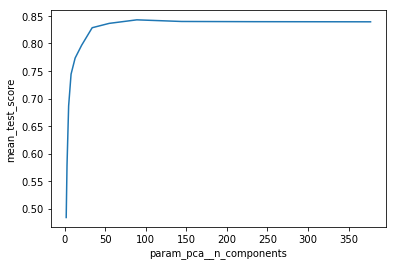

In [63]:
sns.lineplot(x="param_pca__n_components", y="mean_test_score",       
             data=cv_results);

We see that the we have diminishing returns and that the upper limit is close to 84%. However, with 26 components, we already drastically increase the accuracy of the model.  
It might however be interesting to increase the number of components to something between 55 and 100. Let's try with 90. 

## PCA + SVM with more components

As we have found that 89 components seems to be a good choice, we now fix the number of components to 89 and tune the hyperparameters.

In [64]:
# Define our steps
pca = PCA(n_components=89)
model = SVC()

# grid 
grid = {
    'model__C': np.logspace(-3,3,5), 
    'model__kernel': ['sigmoid', 'rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
    'model__gamma': np.logspace(-5,0,5)
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [65]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_svm_tune_time_89 = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.5min finished


In [66]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_svm_tune_time_89, 1)))

,param_model__C,param_model__kernel,param_model__gamma,mean_test_score,std_test_score
35,31.6228,rbf,0.00316228,0.865309,0.009159
42,1000,sigmoid,0.000177828,0.861975,0.008287
43,1000,rbf,0.000177828,0.860741,0.007736
34,31.6228,sigmoid,0.00316228,0.858025,0.007876
41,1000,rbf,1e-05,0.847160,0.006229
45,1000,rbf,0.00316228,0.846296,0.009097
47,1000,rbf,0.0562341,0.843210,0.008842
37,31.6228,rbf,0.0562341,0.843086,0.007453
27,1,rbf,0.0562341,0.842840,0.007911
33,31.6228,rbf,0.000177828,0.840741,0.007167


We can expect an accuracy close to 86.5% on the testing set with the following parameters: 
{'model__C': 31.622776601683793, 'model__gamma': 0.0031622776601683794, 'model__kernel': 'rbf'}. 
The tuning time is 633.6 sec.


In [67]:
pipe.set_params(**grid_cv.best_params_);

In [68]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_svm_train_time_89 = time.time() - start_time

In [69]:
pca_svm_accuracy_89 = pipe.score(X_te, y_te)
pca_svm_accuracy_89

0.8755555555555555

In [70]:
pca_svm_conf_89=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_svm_conf_89

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.98,0.01,0.00,0.00,0.01,0.0,0.01,0.0,0.00
atomic,0.01,0.98,0.01,0.00,0.00,0.0,0.00,0.0,0.00
blitz,0.00,0.00,0.70,0.01,0.13,0.0,0.23,0.0,0.11
chess960,0.00,0.00,0.01,0.98,0.00,0.0,0.00,0.0,0.00
crazyhouse,0.00,0.00,0.02,0.00,0.78,0.0,0.03,0.0,0.05
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.00,0.18,0.01,0.04,0.0,0.69,0.0,0.07
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.01,0.08,0.00,0.04,0.0,0.04,0.0,0.77


In [71]:
pca_svm_metrics_89=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_svm_metrics_89

,f1-score,precision,recall,support
antichess,0.975,0.980,0.970,101.0
atomic,0.980,0.980,0.980,100.0
blitz,0.642,0.700,0.593,118.0
chess960,0.985,0.980,0.990,99.0
crazyhouse,0.830,0.780,0.886,88.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.690,0.690,0.690,100.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.794,0.770,0.819,94.0
micro avg,0.876,0.876,0.876,900.0


# Results with SVM with 89 components

In [72]:
pca_svm_scores_avg_89=list(pca_svm_metrics_89.loc['weighted avg',:])[:3]
pca_svm_scores_blitz_89=list(pca_svm_metrics_89.loc['blitz',:])

In [73]:
results_pca=pd.DataFrame({
              'decision tree': [pca_dt_accuracy, pca_dt_tune_time, pca_dt_train_time, pca_dt_scores_avg[0], pca_dt_scores_avg[1], pca_dt_scores_avg[2], pca_dt_scores_blitz[0], pca_dt_scores_blitz[1], pca_dt_scores_blitz[2], pca_dt_scores_blitz[3]],
              'logistic': [pca_log_accuracy, pca_log_tune_time, pca_log_train_time, pca_log_scores_avg[0], pca_log_scores_avg[1], pca_log_scores_avg[2], pca_log_scores_blitz[0], pca_log_scores_blitz[1], pca_log_scores_blitz[2], pca_log_scores_blitz[3]],
              'random forest': [pca_rf_accuracy, pca_rf_tune_time, pca_rf_train_time, pca_rf_scores_avg[0], pca_rf_scores_avg[1], pca_rf_scores_avg[2], pca_rf_scores_blitz[0], pca_rf_scores_blitz[1], pca_rf_scores_blitz[2], pca_rf_scores_blitz[3]],
              'SVM': [pca_svm_accuracy, pca_svm_tune_time, pca_svm_train_time, pca_svm_scores_avg[0], pca_svm_scores_avg[1], pca_svm_scores_avg[2], pca_svm_scores_blitz[0], pca_svm_scores_blitz[1], pca_svm_scores_blitz[2], pca_svm_scores_blitz[3]],
              'NN': [pca_nnet_accuracy, pca_nnet_tune_time, pca_nnet_train_time, pca_nnet_scores_avg[0], pca_nnet_scores_avg[1], pca_nnet_scores_avg[2], pca_nnet_scores_blitz[0], pca_nnet_scores_blitz[1], pca_nnet_scores_blitz[2], pca_nnet_scores_blitz[3]],
              'SVM_26': [pca_svm_accuracy_26, pca_svm_tune_time_26, pca_svm_train_time_26, pca_svm_scores_avg_26[0], pca_svm_scores_avg_26[1], pca_svm_scores_avg_26[2], pca_svm_scores_blitz_26[0], pca_svm_scores_blitz_26[1], pca_svm_scores_blitz_26[2], pca_svm_scores_blitz_26[3]],
              'SVM_89': [pca_svm_accuracy_89, pca_svm_tune_time_89, pca_svm_train_time_89, pca_svm_scores_avg_89[0], pca_svm_scores_avg_89[1], pca_svm_scores_avg_89[2], pca_svm_scores_blitz_89[0], pca_svm_scores_blitz_89[1], pca_svm_scores_blitz_89[2], pca_svm_scores_blitz_89[3]],  
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_pca

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM_89,0.876,633.610,2.348,0.874,0.874,0.876,0.642,0.70,0.593,118.0
SVM_26,0.839,223.375,1.083,0.839,0.841,0.839,0.642,0.70,0.593,118.0
SVM,0.686,144.454,1.669,0.694,0.710,0.686,0.485,0.56,0.427,131.0
random forest,0.679,122.827,14.552,0.684,0.692,0.679,0.442,0.44,0.444,99.0
NN,0.679,286.411,4.200,0.688,0.708,0.679,0.470,0.47,0.470,100.0
decision tree,0.647,9.928,0.162,0.655,0.678,0.647,0.381,0.36,0.404,89.0
logistic,0.631,5.127,0.215,0.652,0.697,0.631,0.514,0.66,0.420,157.0


Very impressive, the accuracy we could achieve with the SVM model with 89 components is very high, and with a completely reasonable training time.  
This is definitiely a result that will serve as a benchmark as the trade off between the predictive power and the complexity seems very reasonable.  
It is worth trying to see what can be achieve by the other models with more 89 components. 

## RF with 89 components

In [97]:
# Define our steps
pca = PCA(n_components=89)
model = RandomForestClassifier()

# grid 
grid = {
    'model__n_estimators': [100, 1000, 1500, 3000],
    'model__max_depth': [5,10,20,50, 100, 150]
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [99]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_rf_tune_time_89 = time.time() - start_time

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 32.1min finished


In [100]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_rf_tune_time_89, 1)))

,param_model__n_estimators,param_model__max_depth,mean_test_score,std_test_score
15,3000,50,0.798642,0.011052
18,1500,100,0.797778,0.010552
19,3000,100,0.797037,0.010885
22,1500,150,0.796667,0.011980
23,3000,150,0.796296,0.011416
11,3000,20,0.796296,0.010098
9,1000,20,0.796049,0.011285
13,1000,50,0.795926,0.012411
14,1500,50,0.795062,0.009394
21,1000,150,0.794938,0.010176


We can expect an accuracy close to 79.9% on the testing set with the following parameters: 
{'model__max_depth': 50, 'model__n_estimators': 3000}. 
The tuning time is 2118.1 sec.


In [101]:
pipe.set_params(**grid_cv.best_params_);

In [102]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_rf_train_time_89 = time.time() - start_time

In [103]:
pca_rf_accuracy_89 = pipe.score(X_te, y_te)
pca_rf_accuracy_89

0.8233333333333334

In [104]:
pca_rf_conf_89=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_rf_conf_89

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.95,0.00,0.05,0.00,0.02,0.0,0.02,0.0,0.00
atomic,0.04,0.98,0.02,0.00,0.03,0.0,0.04,0.0,0.01
blitz,0.00,0.00,0.63,0.02,0.13,0.0,0.15,0.0,0.13
chess960,0.00,0.00,0.00,0.97,0.01,0.0,0.02,0.0,0.02
crazyhouse,0.00,0.01,0.13,0.00,0.66,0.0,0.11,0.0,0.15
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.01,0.15,0.01,0.06,0.0,0.61,0.0,0.08
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.00,0.02,0.00,0.09,0.0,0.05,0.0,0.61


In [105]:
pca_rf_metrics_89=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_rf_metrics_89

,f1-score,precision,recall,support
antichess,0.931,0.950,0.913,104.0
atomic,0.925,0.980,0.875,112.0
blitz,0.612,0.630,0.594,106.0
chess960,0.960,0.970,0.951,102.0
crazyhouse,0.641,0.660,0.623,106.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.632,0.610,0.656,93.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.689,0.610,0.792,77.0
micro avg,0.823,0.823,0.823,900.0


In [106]:
pca_rf_scores_avg_89=list(pca_rf_metrics_89.loc['weighted avg',:])[:3]
pca_rf_scores_blitz_89=list(pca_rf_metrics_89.loc['blitz',:])

## Logistic regression with 89 components

In [107]:
# Define our steps
pca = PCA(n_components=89)
model = LogisticRegression()

# grid 
grid = {
    'model__C': np.logspace(-3, 5, num=10),
}

# Pipelinem two combine the two steps
pipe = Pipeline(
    steps=[('pca', pca), ('model', model)]
)

# Grid search
grid_cv = GridSearchCV(
    pipe, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [108]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
pca_log_tune_time_89 = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [109]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(pca_log_tune_time_89, 1)))

,param_model__C,mean_test_score,std_test_score
5,27.8256,0.845062,0.002788
4,3.59381,0.843086,0.004526
6,215.443,0.841852,0.002853
3,0.464159,0.841235,0.004609
8,12915.5,0.837901,0.006825
7,1668.1,0.836667,0.004375
9,100000,0.834444,0.003276
2,0.0599484,0.828025,0.005719
1,0.00774264,0.798889,0.006165
0,0.001,0.749136,0.007892


We can expect an accuracy close to 84.5% on the testing set with the following parameters: 
{'model__C': 27.825594022071257}. 
The tuning time is 82.2 sec.


In [110]:
pipe.set_params(**grid_cv.best_params_);

In [111]:
start_time = time.time()
pipe.fit(X_tr, y_tr)
pca_log_train_time_89 = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [112]:
pca_log_accuracy_89 = pipe.score(X_te, y_te)
pca_log_accuracy_89

0.8488888888888889

In [113]:
pca_log_conf_89=pd.DataFrame(confusion_matrix(pipe.predict(X_te), y_te), index=variants, columns=variants)/100
pca_log_conf_89

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.97,0.01,0.01,0.00,0.00,0.0,0.00,0.0,0.00
atomic,0.02,0.98,0.02,0.00,0.01,0.0,0.01,0.0,0.00
blitz,0.00,0.00,0.65,0.00,0.12,0.0,0.22,0.0,0.13
chess960,0.00,0.00,0.00,0.99,0.01,0.0,0.00,0.0,0.02
crazyhouse,0.00,0.00,0.12,0.00,0.71,0.0,0.07,0.0,0.08
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.01,0.00,0.10,0.01,0.06,0.0,0.63,0.0,0.06
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.00,0.01,0.10,0.00,0.09,0.0,0.07,0.0,0.71


In [114]:
pca_log_metrics_89=pd.DataFrame(classification_report(pipe.predict(X_te), y_te, output_dict=True)).T.round(3)
pca_log_metrics_89

,f1-score,precision,recall,support
antichess,0.975,0.970,0.980,99.0
atomic,0.961,0.980,0.942,104.0
blitz,0.613,0.650,0.580,112.0
chess960,0.980,0.990,0.971,102.0
crazyhouse,0.717,0.710,0.724,98.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.674,0.630,0.724,87.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.717,0.710,0.724,98.0
micro avg,0.849,0.849,0.849,900.0


In [115]:
pca_log_scores_avg_89=list(pca_log_metrics_89.loc['weighted avg',:])[:3]
pca_log_scores_blitz_89=list(pca_log_metrics_89.loc['blitz',:])

# Results

In [116]:
results_pca=pd.DataFrame({
              'decision_tree': [pca_dt_accuracy, pca_dt_tune_time, pca_dt_train_time, pca_dt_scores_avg[0], pca_dt_scores_avg[1], pca_dt_scores_avg[2], pca_dt_scores_blitz[0], pca_dt_scores_blitz[1], pca_dt_scores_blitz[2], pca_dt_scores_blitz[3]],
              'logistic': [pca_log_accuracy, pca_log_tune_time, pca_log_train_time, pca_log_scores_avg[0], pca_log_scores_avg[1], pca_log_scores_avg[2], pca_log_scores_blitz[0], pca_log_scores_blitz[1], pca_log_scores_blitz[2], pca_log_scores_blitz[3]],
              'random_forest': [pca_rf_accuracy, pca_rf_tune_time, pca_rf_train_time, pca_rf_scores_avg[0], pca_rf_scores_avg[1], pca_rf_scores_avg[2], pca_rf_scores_blitz[0], pca_rf_scores_blitz[1], pca_rf_scores_blitz[2], pca_rf_scores_blitz[3]],
              'SVM': [pca_svm_accuracy, pca_svm_tune_time, pca_svm_train_time, pca_svm_scores_avg[0], pca_svm_scores_avg[1], pca_svm_scores_avg[2], pca_svm_scores_blitz[0], pca_svm_scores_blitz[1], pca_svm_scores_blitz[2], pca_svm_scores_blitz[3]],
              'NN': [pca_nnet_accuracy, pca_nnet_tune_time, pca_nnet_train_time, pca_nnet_scores_avg[0], pca_nnet_scores_avg[1], pca_nnet_scores_avg[2], pca_nnet_scores_blitz[0], pca_nnet_scores_blitz[1], pca_nnet_scores_blitz[2], pca_nnet_scores_blitz[3]],
              'SVM_26': [pca_svm_accuracy_26, pca_svm_tune_time_26, pca_svm_train_time_26, pca_svm_scores_avg_26[0], pca_svm_scores_avg_26[1], pca_svm_scores_avg_26[2], pca_svm_scores_blitz_26[0], pca_svm_scores_blitz_26[1], pca_svm_scores_blitz_26[2], pca_svm_scores_blitz_26[3]],
              'SVM_89': [pca_svm_accuracy_89, pca_svm_tune_time_89, pca_svm_train_time_89, pca_svm_scores_avg_89[0], pca_svm_scores_avg_89[1], pca_svm_scores_avg_89[2], pca_svm_scores_blitz_89[0], pca_svm_scores_blitz_89[1], pca_svm_scores_blitz_89[2], pca_svm_scores_blitz_89[3]],  
              'random_forest_89': [pca_rf_accuracy_89, pca_rf_tune_time_89, pca_rf_train_time_89, pca_rf_scores_avg_89[0], pca_rf_scores_avg_89[1], pca_rf_scores_avg_89[2], pca_rf_scores_blitz_89[0], pca_rf_scores_blitz_89[1], pca_rf_scores_blitz_89[2], pca_rf_scores_blitz_89[3]],
              'logistic_89': [pca_log_accuracy_89, pca_log_tune_time_89, pca_log_train_time_89, pca_log_scores_avg_89[0], pca_log_scores_avg_89[1], pca_log_scores_avg_89[2], pca_log_scores_blitz_89[0], pca_log_scores_blitz_89[1], pca_log_scores_blitz_89[2], pca_log_scores_blitz_89[3]],
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_pca

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM_89,0.876,633.610,2.348,0.874,0.874,0.876,0.642,0.70,0.593,118.0
logistic_89,0.849,82.249,3.762,0.849,0.851,0.849,0.613,0.65,0.580,112.0
SVM_26,0.839,223.375,1.083,0.839,0.841,0.839,0.642,0.70,0.593,118.0
random_forest,0.826,1630.714,62.678,0.684,0.692,0.679,0.442,0.44,0.444,99.0
random_forest_89,0.823,2118.101,184.197,0.826,0.831,0.823,0.612,0.63,0.594,106.0
SVM,0.686,144.454,1.669,0.694,0.710,0.686,0.485,0.56,0.427,131.0
NN,0.679,286.411,4.200,0.688,0.708,0.679,0.470,0.47,0.470,100.0
decision_tree,0.647,9.928,0.162,0.655,0.678,0.647,0.381,0.36,0.404,89.0
logistic,0.631,5.127,0.215,0.652,0.697,0.631,0.514,0.66,0.420,157.0


The SVM with 89 remains by fat the best model we have seen in this section, in terms of accuracy but also in terms of the other metrics that we monitored. 

In [117]:
results_pca.to_pickle('datasets/results_pca')